# Manage folders

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import shutil
import sys
import glob
import h5py
import numpy as np
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!mkdir data
shutil.copyfile('drive/MyDrive/modelnet40_ply_hdf5_2048.zip', 'data/modelnet40_ply_hdf5_2048.zip')
!unzip data/modelnet40_ply_hdf5_2048.zip
os.rename('modelnet40_ply_hdf5_2048', 'data/modelnet40_ply_hdf5_2048')

# Prepare data

In [2]:
def load_data(partition):
    DATA_DIR = 'data'
    all_data = []
    all_label = []
    for h5_name in glob.glob(os.path.join(DATA_DIR, 'modelnet40_ply_hdf5_2048', 'ply_data_%s*.h5'%partition)):
        f = h5py.File(h5_name)
        data = f['data'][:].astype('float32')
        label = f['label'][:].astype('int64')
        f.close()
        all_data.append(data)
        all_label.append(label)
    all_data = np.concatenate(all_data, axis=0)
    all_label = np.concatenate(all_label, axis=0)
    return all_data, all_label

data, labels = load_data('train')
data.shape

(9840, 2048, 3)

In [3]:
def translate_pointcloud(pointcloud):
    xyz1 = np.random.uniform(low=2./3., high=3./2., size=[3])
    xyz2 = np.random.uniform(low=-0.2, high=0.2, size=[3])
       
    translated_pointcloud = np.add(np.multiply(pointcloud, xyz1), xyz2).astype('float32')
    return translated_pointcloud


def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.02):
    N, C = pointcloud.shape
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
    return pointcloud


class ModelNet40(Dataset):
    def __init__(self, num_points, partition='train'):
        self.data, self.label = load_data(partition)
        self.num_points = num_points
        self.partition = partition        

    def __getitem__(self, item):
        pointcloud = self.data[item][:self.num_points]
        label = self.label[item]
        if self.partition == 'train':
            pointcloud = translate_pointcloud(pointcloud)
            np.random.shuffle(pointcloud)
        pointcloud = np.transpose(pointcloud, axes=(1, 0))
        return pointcloud, label

    def __len__(self):
        return self.data.shape[0]


train = ModelNet40(1024)

In [4]:
train_dloader = torch.utils.data.DataLoader(train,
                                            batch_size=32,
                                            shuffle=True)

# Train

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [ ]:
class PointNet(nn.Module):
    def __init__(self, output_channels=40):
        super(PointNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1, bias=False)
        self.conv5 = nn.Conv1d(128, 512, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(512)

        self.linear1 = nn.Linear(512, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout()
        self.linear2 = nn.Linear(512, output_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = torch.mean(x, dim=2)
        # x = F.adaptive_max_pool1d(x, 1).squeeze()

        x = F.relu(self.bn6(self.linear1(x)))
        x = self.dp1(x)
        x = self.linear2(x)
        return x

model = PointNet().to(device)
tmp = torch.randn([10, 3, 1024]).to(device)
model(tmp).shape

torch.Size([10, 40])

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class PointNet(nn.Module):
    def __init__(self, output_channels=40):
        super(PointNet, self).__init__()

        self.fc = nn.Sequential(
            nn.Flatten(),

            nn.Linear(1024 * 3, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(2048, 40)
        )

    def forward(self, x):
        out = self.fc(x)
        return out

model = PointNet().to(device)
tmp = torch.randn([10, 3, 1024]).to(device)
model(tmp).shape

torch.Size([10, 40])

In [4]:
def knn(x, k):
    inner = -2 * torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]
    return idx


def get_graph_feature(x, k=20):
    batch_size = x.size(0)
    num_points = x.size(2)
    num_dims = x.size(1)
    x = x.reshape(batch_size, -1, num_points)
    idx = knn(x, k=k)

    idx_base = torch.arange(0, batch_size, device=device)
    idx_base = idx_base.reshape(-1, 1, 1) * num_points
    idx = idx + idx_base
    idx = idx.reshape(-1)

    x = x.transpose(2, 1)
    feature = x.reshape(batch_size * num_points, -1)[idx, :]
    feature = feature.reshape(batch_size, num_points, k, num_dims) 
    x = x.reshape(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature

In [7]:
class DGCNN(nn.Module):
    def __init__(self, emb_dims=512, k=20, 
                 dropout=0.1, output_channels=40):
        super(DGCNN, self).__init__()
        self.k = k
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(emb_dims)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, emb_dims, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(0.2))
        self.linear1 = nn.Linear(emb_dims*2, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=dropout)
        self.linear2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=dropout)
        self.linear3 = nn.Linear(256, output_channels)

    def forward(self, x):
        batch_size = x.size(0)
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]
        
        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3, x4), dim=1)

        x = self.conv5(x)
        
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)

        x = F.leaky_relu(self.bn6(self.linear1(x)), 0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)), 0.2)
        x = self.dp2(x)
        x = self.linear3(x)

        return x

model = DGCNN().to(device)
tmp = torch.randn([10, 3, 1024], device=device)
model(tmp).shape

torch.Size([10, 40])

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
loss_list = []

In [ ]:
model.train()

for epoch in range(2):
    for i, (x, labels) in enumerate(train_dloader):
        labels = labels.reshape(-1)

        optimizer.zero_grad()
        pred = model(x.to(device))
        loss = criterion(pred, labels.to(device))
        loss.backward()
        optimizer.step()

        print('Epoch {} Step {} Loss = {}'.format(epoch, i, loss.detach().item()))
        loss_list.append(loss.detach().item())

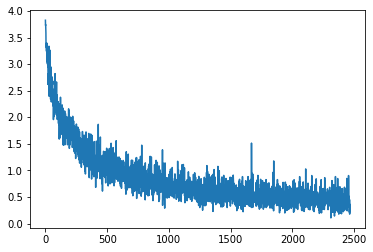

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_list)), loss_list)

In [31]:
torch.save(model.state_dict(), '3D_net')

In [32]:
model.eval()
print(' ')

# Test

In [33]:
test = ModelNet40(1024, partition='test')

test_dloader = torch.utils.data.DataLoader(test,
                                            batch_size=32,
                                            shuffle=False)

In [34]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model.load_state_dict(torch.load('3D_net'))

In [35]:
preds = []
labels = []

with torch.no_grad():
    for i, (x, tgt) in enumerate(test_dloader):

        pred = model(x.to(device)).detach()
        # pred = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1)

        preds.append(pred)
        labels.append(tgt)

preds = torch.cat(preds)
labels = torch.cat(labels)

In [36]:
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score as rec
from sklearn.metrics import precision_score as prec
from sklearn.metrics import f1_score as f1

preds = preds.cpu()
print(acc(labels, preds))

0.8602106969205835
